# Exercise 4: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [236]:
import numpy as np
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [237]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [238]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [239]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [240]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [241]:
df= pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])
df.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


2. Check how many rows and columns are in the training dataset using `.info()`

In [242]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [243]:
df_train.isnull().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [244]:
df_train.duplicated().sum()

np.int64(0)

5. Check how many rows belong to each class

In [245]:
df_train.value_counts()

,,count
text,label,
~Napansin ko lang mga KAKAMPNKS bakit ang hashtag ninyo Let Leni Lead at Leni Matapang pero wala ako makitang Leni Matalino? Aminado ba kayo na wala talagang utak Nanay ninyo? Well not surprising dahil kung ano ang puno siya din bunga.~ Pic not related just really funny.,1,1
EOS Network[USERNAME] EOS- [USERNAME] v4.. - Consensus2023- EOS EVM - (< . ),0,1
(fan) [USERNAME] OMG YES YES.LOVE THS. SGE LANG MAG PAKA TROLL PA PO KAYO. DUTERTE VS DUTERTE. MARCOS VS BONG GO. YES DDS-BBMNATCS-TROLLS-FAKE NEWS NATON RSE. YES MAHAT KAYO.LOVE THS. YES. YES. YES MAHAHAT ANG MGA BOTO. Pero kay Leni We are One Let Leni Lead,0,1
[USERNAME] Ang hirap magpaliwanag ng katotohan sa mga taong sarado ang utak. Para kang nakikipag usap sa hangin kapag sila ang kausap mo.. basta tayo.. hindi BULAG.. boboto ko ang Taong may malinis na puso at malasakit sa kapwa Let Leni Lead,0,1
[USERNAME] STRAY KDS SAD LET LEN LEAD,0,1
...,...,...
BBM Is My President,0,1
BBM FOR PRESIDENT,0,1
BBM,0,1


## B. Text pre-processing

6. Remove duplicate rows

In [246]:
df_train['duplicates'] = np.where(df_train['text'].duplicated(keep=False), 1, 0)

7. Remove rows with NaN values

In [247]:
data = df_train.dropna()

8. Convert all text to lowercase

In [248]:
# 8. Convert all text to lowercase
data['text'] = data['text'].str.lower()

9. Remove digits, URLS and special characters

In [249]:
# 9. Remove digits, URLS and special characters
data['text'] = data['text'].str.replace(r'http\S+', '', regex=True)
data['text'] = data['text'].str.replace(r'[^a-z\s]', ' ', regex=True)

10. Remove stop words

In [250]:
# 10. Remove stop words
stop_words = set(stopwords.words("english"))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

11. Use Stemming or Lemmatization

In [251]:
# 11. Use Stemming or Lemmatization (Choosing Stemming for this example)
stemmer = PorterStemmer()
data['text'] = data['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

## C. Training your model

12. Put all text training data in variable **X_train**

In [252]:
# Put all text training data in variable X_train
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [253]:
# Put all training data labels in variable y_train
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [254]:
from sklearn.feature_extraction.text import CountVectorizer
vect1 = CountVectorizer(stop_words='english',max_df=0.5)

#fitting train data and then transforming it to count matrix#fitting
X_train_transformed = vect1.fit_transform(X_train)

#transforming the test data into the count matrix initiated for train data
X_test_transformed = vect1.transform(X_test)


15. Create an instance of `MultinomalNB()`

In [255]:
# importing naive bayes algorithm
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()


16. Train the model using `.fit()`

In [256]:
#fitting the model into train data
nb.fit(X_train_transformed,y_train)

MultinomialNB()

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [257]:
X_validation = df_validation['text']


X_validation_transformed = vect1.transform(X_validation)


y_validation_pred = nb.predict(X_validation_transformed)

display(y_validation_pred[:5])

array([1, 0, 0, 1, 0])

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [258]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Put all validation data labels in y_validation variable
y_validation = df_validation['label']

# Calculate evaluation metrics
accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)

print(f"Accuracy on validation set: {accuracy:.4f}")
print(f"Precision on validation set: {precision:.4f}")
print(f"Recall on validation set: {recall:.4f}")
print(f"F1-Score on validation set: {f1:.4f}")

Accuracy on validation set: 0.8332
Precision on validation set: 0.8008
Recall on validation set: 0.8919
F1-Score on validation set: 0.8439


19. Create a confusion matrix using the **validation dataset**

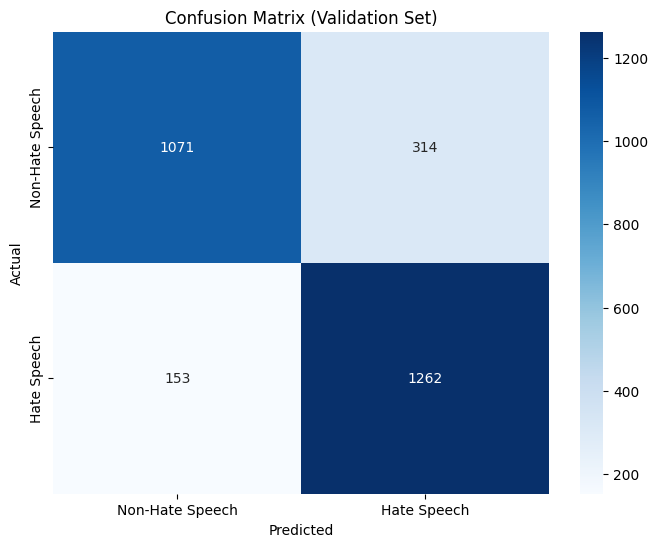

In [259]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_validation, y_validation_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate Speech', 'Hate Speech'], yticklabels=['Non-Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [260]:
# Put all text test data in X_test variable
X_test = df_test['text']

# Convert X_test to its numerical form.
X_test_transformed = vect1.transform(X_test)

# Put all predictions in y_test_pred variable
y_test_pred = nb.predict(X_test_transformed)

display(y_test_pred[:5])

array([1, 0, 1, 0, 0])

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [261]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Put all test data labels in y_test variable
y_test = df_test['label']

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy on test set: {accuracy:.4f}")
print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1-Score on test set: {f1:.4f}")

Accuracy on test set: 0.8320
Precision on test set: 0.7953
Recall on test set: 0.8920
F1-Score on test set: 0.8409


22. Create a confusion matrix using the **test dataset**

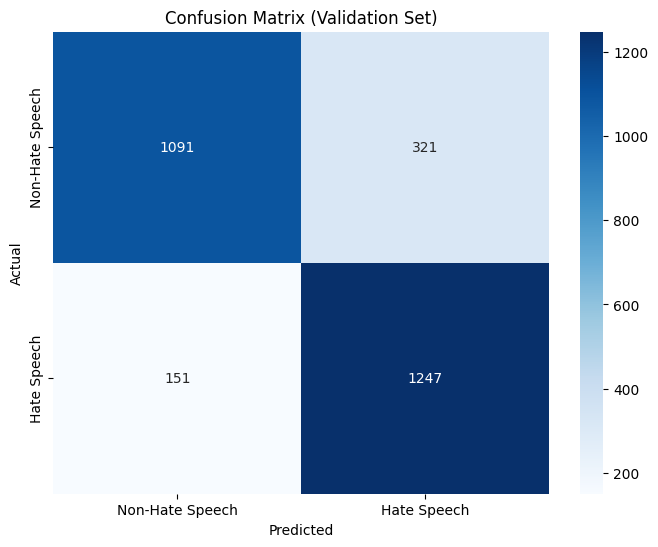

In [262]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate Speech', 'Hate Speech'], yticklabels=['Non-Hate Speech', 'Hate Speech'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [263]:
new_text = pd.Series('MAHAL KO ANG AKING BAYAN')
new_text_transform = vect.transform(new_text)
print("The Speech is a " ,nb.predict(new_text_transform))



The Speech is a  [0]


24. Test the model by providing a hate speech input. The model should predict it as 1

In [264]:
new_text = pd.Series('TANGINA MO')
new_text_transform = vect.transform(new_text)
print("The Speech is a " ,nb.predict(new_text_transform))

The Speech is a  [1]
